<a href="https://colab.research.google.com/github/CEFab/redes-neuronales-notebooks/blob/main/deteccion_transacciones_fraudulentas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

De esta manera puedes instalar Minisom o cualquier otra biblioteca. El SOM (Self-Organizing Map) es el modelo básico de aprendizaje profundo no supervisado utilizado para la detección de fraudes en tarjetas de crédito, donde fácilmente puedes interpretar los resultados visualizando los gráficos.

Bien... ¡Comencemos! Espero que lo disfrutes :)

In [ ]:
!pip install minisom

In [ ]:
from minisom import MiniSom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from pylab import bone, pcolor, colorbar, plot, show

SOM (Mapas Auto-Organizativos):
Los Mapas Auto-Organizativos (SOM, por Self-Organizing Maps) son un tipo de red neuronal artificial capaz de convertir relaciones estadísticas complejas y no lineales entre datos de alta dimensión en relaciones geométricas simples visualizables en un espacio de baja dimensión.

La figura siguiente ilustra el entrenamiento de un SOM:

La mancha morada representa la distribución de los datos de entrenamiento.

El pequeño disco blanco es el punto de datos actual extraído de esa distribución.

Inicialmente, los nodos del SOM se posicionan aleatoriamente en el espacio de datos.

El nodo más cercano al punto de datos (resaltado en amarillo) es seleccionado y "atraído" hacia él.

En cada iteración, los nodos vecinos dentro de un radio determinado también son ajustados hacia el nodo amarillo (actualizando sus pesos).

Tras múltiples iteraciones, la cuadrícula aproxima la distribución de los datos (derecha).

Proceso de entrenamiento:

Distancia euclidiana: Al introducir los datos de entrenamiento en la red, se calcula la distancia euclidiana entre el vector de entrada y todos los vectores de peso.

BMU (Best Matching Unit): La neurona cuyo vector de peso es más similar al dato de entrada se denomina "unidad de mejor coincidencia".

Ajuste de pesos: Los pesos del BMU y de sus nodos circundantes en la cuadrícula se actualizan hacia el vector de entrada.

Vecindario: Tras identificar el BMU, se determina qué otros nodos pertenecen a su vecindario.

Diferencias clave con otras redes neuronales:

Usan aprendizaje competitivo (no backpropagation ni descenso de gradiente).

Los datos de entrenamiento suelen ser no etiquetados; el mapa aprende a diferenciar características basándose en similitudes.

Aplicaciones:
Visualización de datos, detección de fraudes, entre otros.

In [ ]:
df = pd.read_csv('/content/Credit_Card_Applications.csv')
df.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


In [ ]:
info = pd.DataFrame()
info.insert(0,"Data Type",df.dtypes ,True)
info.insert(1,"Column Real Name",df.columns,True)
info.insert(2,"IsNull",df.isnull().sum(),True)
info.insert(3,"IsNa",df.isna().sum(),True)
info.insert(4,"Unique",df.nunique(),True)
info.insert(5,"Duplicate Values",df.duplicated().sum(),True)
info.insert(6,"Min",df.min(),True)
info.insert(7,"Max",df.max(),True)
info.T

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
Data Type,int64,int64,float64,float64,int64,int64,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64
Column Real Name,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
IsNull,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
IsNa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Unique,690,2,350,215,3,14,8,132,2,2,23,2,3,171,240,2
Duplicate Values,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Min,15565714.0,0.0,13.75,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
Max,15815443.0,1.0,80.25,28.0,3.0,14.0,9.0,28.5,1.0,1.0,67.0,1.0,3.0,2000.0,100001.0,1.0


Como puedes observar, no hay valores nulos (Null/NaN) ni filas duplicadas.

El SOM es un algoritmo no supervisado. Por lo tanto, debemos eliminar la variable objetivo (Target) de nuestro dataframe para el análisis.

In [ ]:
# Error: Estás incluyendo CustomerID en el escalado
X = df.drop(columns={"Class"}, axis=1)  # <- CustomerID sigue siendo parte de X
sc = MinMaxScaler()
sc.fit(X)  # Escalas CustomerID junto con otras características (¡incorrecto!)

MinMaxScaler()

La razon para conservar el CostumerID (id cliente), es porque al final, para detectar fraude, se necesita.

Escalar

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc =minMaxScaler = MinMaxScaler(feature_range = (0,1))
sc.fit(X)
X = sc.transform(X)
type(X)

numpy.ndarray

<h2>Entrenando el SOM</h2>
<p>
<strong>MiniSom</strong> es una implementación minimalista basada en Numpy de los Mapas Auto-Organizativos (SOM). Esto significa que para usar MiniSom, tus datos deben estar organizados como una matriz Numpy donde cada fila corresponde a una observación, o como lista de listas. Nuestros datos de entrada <code>X</code> ya están en formato <code>numpy.ndarray</code>.
</p>

<h3>Parámetros:</h3>
<ul>
  <li><strong>x, y</strong>: corresponden a las dimensiones del SOM</li>
  <li><strong>input_len</strong>: número de características usadas en el dataset de entrenamiento</li>
  <li><strong>Sigma</strong>: es el radio de los diferentes vecinos en el SOM. El valor por defecto es 1.0.</li>
  <li><strong>learning_rate</strong>: determina cuánto se ajustan los pesos durante cada iteración.</li>
</ul>

<p>
El algoritmo de entrenamiento implementado disminuye ambos parámetros (<code>sigma</code> y <code>learning_rate</code>) a medida que progresa el entrenamiento. Esto permite un entrenamiento inicial rápido de la red neuronal que luego se "afina" a medida que avanza el entrenamiento.
</p>

<p>
MiniSom implementa dos tipos de entrenamiento: <code>train_random</code> y <code>train_batch</code>. En <code>train_random</code>, entrenamos el modelo seleccionando muestras aleatorias de nuestros datos. En <code>train_batch</code>, las muestras se seleccionan en el orden en que están almacenadas.
</p>

<p>
El método <code>random_weights_init</code> inicializa los pesos seleccionando muestras aleatorias de los datos.
</p>

In [ ]:
som = MiniSom(x=10, y=10, input_len= 15, sigma= 1.0, learning_rate = 0.5,random_seed=43)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 100)

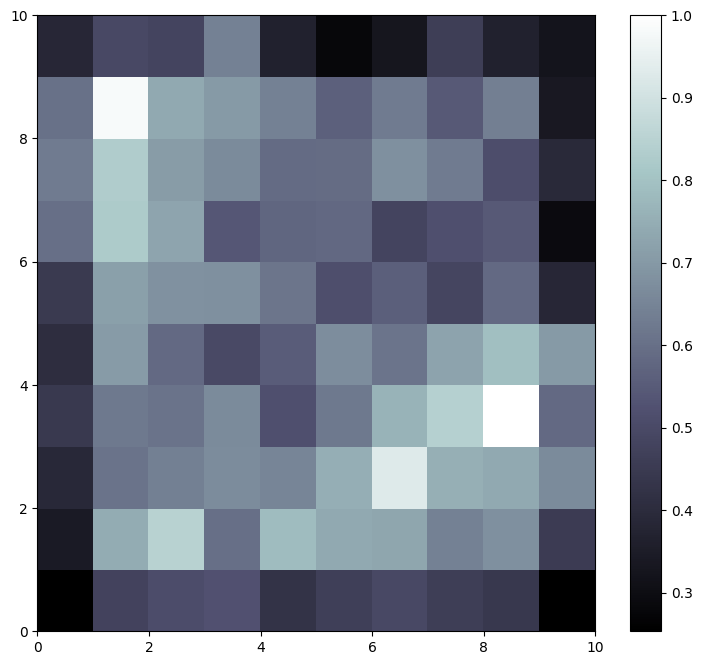

In [ ]:
plt.figure(figsize=(9, 8))  # Define el tamaño de la figura para visualización

pcolor(som.distance_map().T)  # Calcula la distancia media inter-neuronal y crea un mapa basado en estas distancias.
                             # Genera clusters según los colores que representan las distancias:
                             # - Colores oscuros: neuronas cercanas a su vecindario
                             # - Colores claros: neuronas atípicas (outliers)
                             # Si hay clientes en estas zonas claras, probablemente sean fraudulentos.
colorbar()  # Muestra la barra de color de referencia

<h2>Visualización de los Resultados</h2>
<p><code>bone</code>: Establece el mapa de colores a 'bone'. Esto cambia el mapa de colores predeterminado así como el mapa de colores de la imagen actual si existe.</p>
<p><code>pcolor</code>: Crea un gráfico de pseudocolor con una cuadrícula rectangular no regular.</p>
<p><code>distance_map</code>: Retorna todas las distancias medias inter-neuronales para todos los nodos ganadores.</p>
<p><code>colorbar</code>: La función colorbar() en el módulo pyplot de matplotlib añade una barra de color al gráfico indicando la escala de colores.</p>
<p><code>winner</code>: Para obtener la posición de la neurona ganadora en el mapa para una muestra dada.</p>

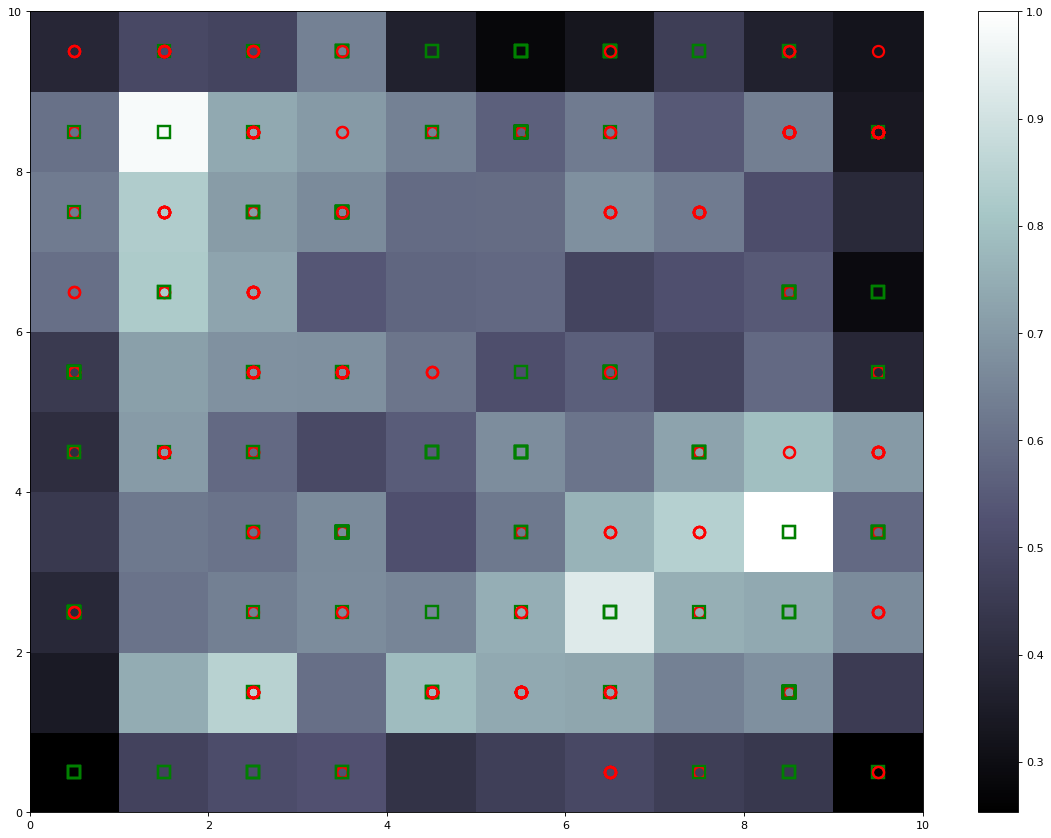

In [ ]:
plt.figure(figsize=(18, 13), dpi=80, facecolor='w', edgecolor='k')  # Define el tamaño de la figura para visualización

bone()
pcolor(som.distance_map().T)  # Mapa de distancias como fondo
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
for i, x in enumerate(X):
    w = som.winner(x)
    # w[0], w[1] colocan el marcador en la esquina inferior izquierda del rectángulo.
    # Añadimos 0.5 a ambos valores para graficar el marcador en el centro del rectángulo.
    plot(w[0] + 0.5,
         w[1] + 0.5,
         # El valor objetivo 0 tendrá el marcador "o" con color "r" (rojo)
         # El valor objetivo 1 tendrá el marcador "s" con color "g" (verde)
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',  # Sin relleno de color dentro de los marcadores
         markersize = 10,
         markeredgewidth = 2)
show()

<h2>Identificación de Fraudes</h2>
<p>Las categorías atípicas (outliers) representan los fraudes.</p>

<p>Como puedes observar, hay 2 categorías atípicas (en blanco) en las coordenadas (2,9) y (9,4). Esto significa que los clientes en estas categorías tienen alta probabilidad de ser fraudulentos.</p>

<p>Dado que puede haber múltiples clientes en una categoría, en ambas encontramos tanto cuadrados verdes como círculos rojos, lo que indica que algunos de ellos obtuvieron aprobación de sus tarjetas de crédito.</p>

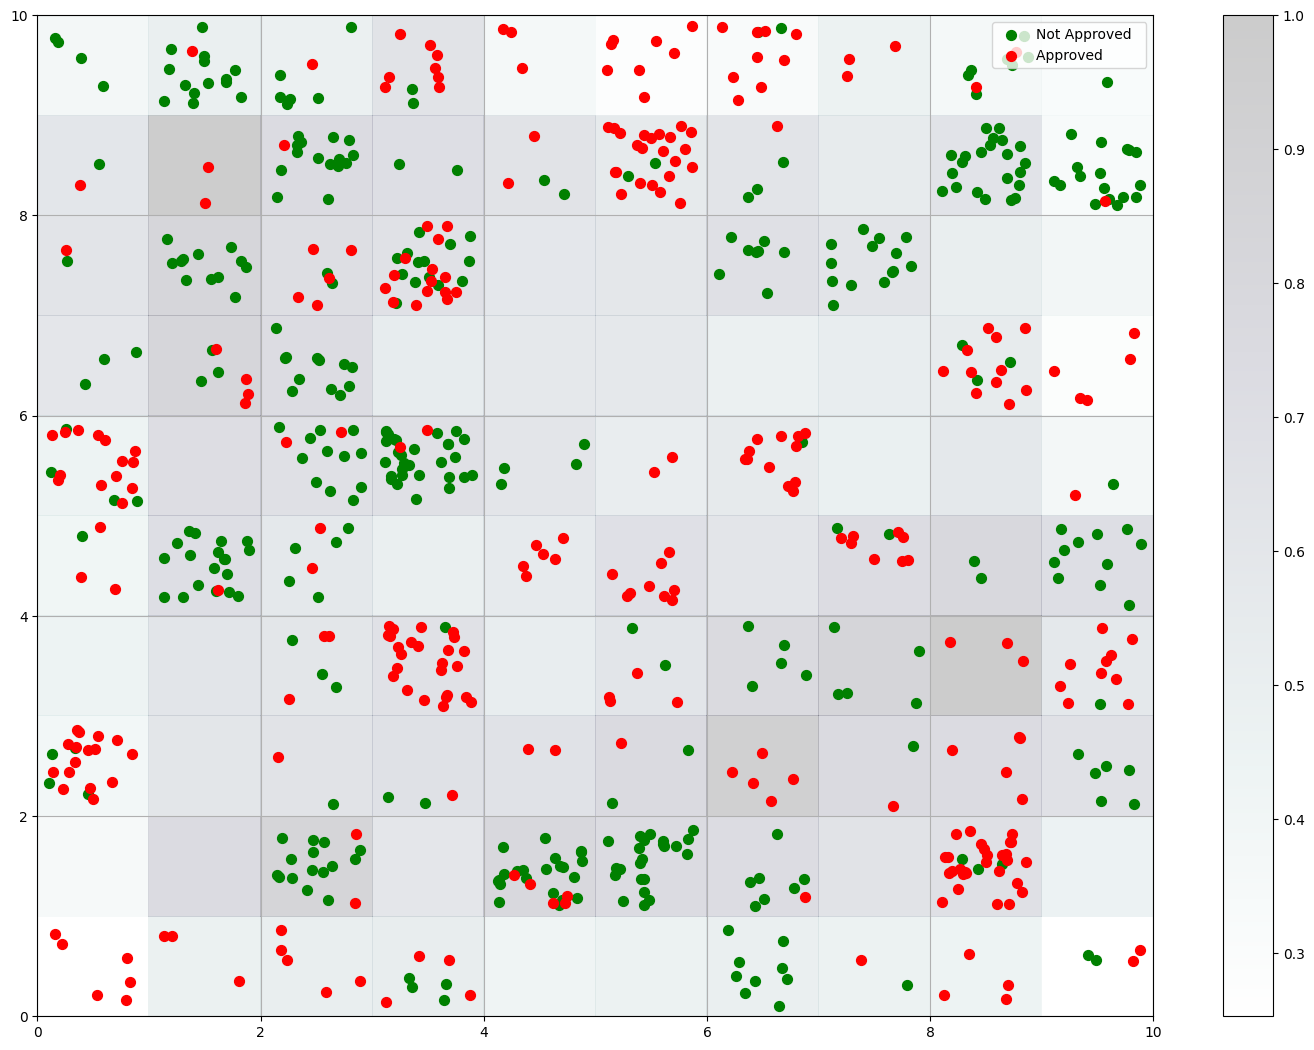

In [ ]:
# Obtenemos las coordenadas de las neuronas ganadoras para cada muestra
w_x, w_y = zip(*[som.winner(d) for d in X])
w_x = np.array(w_x)
w_y = np.array(w_y)

# Configuramos el tamaño y propiedades de la figura
plt.figure(figsize=(18, 13))

# Creamos el mapa de distancias con colormap inverso ('bone_r') y transparencia
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
plt.colorbar()  # Añadimos barra de color

# Graficamos cada categoría con dispersión aleatoria para mejor visualización
for c in np.unique(y):
    idx_target = y==c  # Filtramos por categoría
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                s=50,  # Tamaño del marcador
                c=colors[c-1],  # Color según categoría
                label=label_names[c])  # Etiqueta para la leyenda

plt.legend(loc='upper right')  # Leyenda en esquina superior derecha
plt.grid()  # Añadimos cuadrícula
plt.show()  # Mostramos el gráfico

In [ ]:
# Obtenemos el mapeo de clientes por coordenadas
mappings = som.win_map(X)

# Convertimos las coordenadas a tuplas de enteros
coordenadas = [(int(x), int(y)) for (x, y) in mappings.keys()]

# Imprimimos con formato, con saltos cada 10 elementos
print("dict_keys([", end="")
for i, coord in enumerate(coordenadas):
    # Cada 10 coordenadas, hacemos salto de línea con indentación
    if i % 10 == 0 and i != 0:
        print("\n          ", end="")
    # Imprimimos la coordenada actual
    print(f"{coord}", end="")
    # Agregamos coma separadora, excepto para la última
    if i != len(coordenadas) - 1:
        print(", ", end="")
print("])")

dict_keys([(1, 4), (3, 5), (1, 7), (0, 2), (5, 8), (5, 4), (6, 0), (3, 3), (8, 8), (6, 5), 
          (8, 6), (6, 1), (2, 5), (8, 1), (3, 0), (2, 4), (4, 1), (3, 2), (7, 7), (5, 1), 
          (3, 7), (0, 0), (0, 5), (2, 8), (9, 2), (9, 8), (2, 1), (9, 6), (4, 5), (4, 4), 
          (5, 9), (1, 9), (6, 8), (9, 3), (1, 0), (7, 3), (3, 9), (6, 9), (6, 7), (2, 9), 
          (0, 9), (2, 6), (1, 6), (6, 2), (5, 5), (2, 0), (7, 2), (9, 4), (8, 2), (2, 3), 
          (3, 8), (8, 3), (8, 9), (2, 7), (0, 4), (5, 3), (7, 0), (2, 2), (9, 5), (7, 4), 
          (0, 8), (4, 2), (4, 8), (8, 0), (7, 9), (9, 0), (0, 6), (0, 7), (1, 8), (4, 9), 
          (8, 4), (5, 2), (9, 9), (6, 3)])


In [ ]:
# De acuerdo al gráfico, las coordenadas (7,5) corresponden a clientes potencialmente fraudulentos
# (color blanco en el mapa, indicando máxima distancia media entre neuronas)

# Concatenamos los clientes de las coordenadas sospechosas (2,9) y (9,4)
frauds = np.concatenate((mappings[(2,9)], mappings[(9,4)]), axis=0)

# Verificamos la dimensión del array resultante
np.asarray(frauds).shape

(18, 15)

In [ ]:
# Aplicamos transformación inversa para obtener los valores originales (antes del escalado)
frauds = sc.inverse_transform(frauds)

# Verificamos la dimensión del array resultante
np.asarray(frauds).shape

(18, 15)

In [ ]:
# Imprime el encabezado para la lista de IDs de clientes fraudulentos
print('Fraud Customer IDs')

# Itera sobre la primera columna del array 'frauds' que contiene los IDs de clientes
for i in frauds[:, 0]:
    # Convierte a entero e imprime cada ID (el [:,0] selecciona solo la columna de IDs)
    print(int(i))

# Imprime el conteo total de clientes fraudulentos encontrados
# len(frauds[:,0]) cuenta el número de elementos en la columna de IDs
print("Fraud Customer Count is :", len(frauds[:, 0]))

Fraud Customer IDs
15636767
15713983
15648681
15763194
15666012
15740411
15790689
15651868
15716082
15651460
15672637
15752344
15736533
15779207
15611409
15609987
15636454
15615296
Fraud Customer Count is : 18
